In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

%matplotlib inline
plt.style.use("ggplot")

In [2]:
data = load_breast_cancer()

X, y = data.data, data.target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)

sc = MinMaxScaler()
sc.fit(X_train)

sc_train, sc_val = sc.transform(X_train), sc.transform(X_val)

In [3]:
w = np.random.uniform(low=-0.05, high=0.05, size=(X.shape[1]))
b = np.random.uniform(low=-0.05, high=0.05, size=(1))
print(w, b)

[-0.00511578  0.01933     0.01741889  0.01560562 -0.04484579  0.03744364
  0.00925535  0.01669381  0.04775259  0.04609531  0.01806485 -0.01812007
 -0.00437955  0.00354072 -0.03057799 -0.04777216 -0.00471318  0.01904621
  0.01842367  0.04379666  0.0490758   0.02792465  0.02226685 -0.02916959
  0.00254884  0.04222923  0.03189786  0.0398876   0.03352697  0.01190334] [-0.04209663]


## Gradient descent based method :

In [4]:
def forward(x, w, b):
    return np.dot(x, w) + b

def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))

def grad_descent(x, w, y_true, y_hat):
    dw = (1/len(y_true)) * np.dot(x.T, (y_hat - y_true))
    db = (1 / len(y_true) *np.sum(y_hat - y_true))
    return dw, db

def loss_func(y_true, y_hat, epsilon=1e-6):
    y_hat = np.clip(y_hat, a_min = epsilon, a_max= 1 - epsilon)
    f1 = y_true * np.log(y_hat)
    f2 = (1 - y_true ) * np.log( 1 - y_hat + epsilon) 
    f = f1 + f2
    return - np.mean(f)

def accuracy(y_true, y_hat):
    return np.sum(y_true == y_hat) / len(y_true)

def update(w, b, dw, db, lr):
    w = w - lr * dw
    b = b - lr * db
    return w, b

def argmaxThis(pred):
    argmaxed = []
    for i in range(len(pred)):
        if pred[i] > 0.5:
            argmaxed.append(1)
        else : 
            argmaxed.append(0)
    return argmaxed

In [5]:
loss_hist, val_loss_hist = [], []

for _ in range(1300):
    y_hat = sigmoid(forward(sc_train, w, b))
    dw, db = grad_descent(sc_train, w, y_train, y_hat)
    w, b = update(w, b, dw, db, 0.01)
    loss = loss_func(y_train, y_hat)
    val_hat = sigmoid(forward(sc_val, w, b))
    val_loss = loss_func(y_val, val_hat)
    loss_hist.append(loss)
    val_loss_hist.append(val_loss)

In [6]:
np.matmul(sc_train, w).shape

(512,)

In [7]:
sc_train.shape, w.shape

((512, 30), (30,))

In [8]:
train_pred = sigmoid(np.dot(sc_train, w) + b)
train_acc = accuracy(y_train, argmaxThis(train_pred))

val_pred =  sigmoid(np.dot(sc_val, w) + b)
val_acc = accuracy(y_val, argmaxThis(val_pred))

print("Train Accuracy : ", train_acc)
print("Validation Accuracy : ", val_acc)

Train Accuracy :  0.912109375
Validation Accuracy :  0.9473684210526315


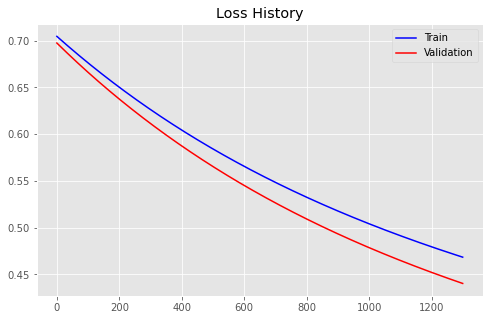

In [9]:
plt.figure(figsize=(8, 5))
plt.title("Loss History")
plt.plot(loss_hist, color='b', label='Train')
plt.plot(val_loss_hist, color='r', label='Validation')
plt.legend();

In [10]:
class LogisticRegression :
    def __init__(self, 
                 steps : int = 300, 
                 epsilon : float = 1e-6,
                 lr : float = 0.01,
                 threshold : float = 0.5,
                 use_bias : bool = True,
                 init : str = "normal"):
        self.use_bias = use_bias
        self.steps = steps
        self.epsilon = epsilon
        self.init = init.lower()
        self.lr = lr
        assert threshold < 1.0 and threshold > 0.0, f"Threshold has to be between 0 and 1 !"
        self.threshold = threshold
    
    def fit(self, X, y, batch_size=64):
        X, y = np.array(X), np.array(y)
        assert batch_size <= len(X), "Batch size can't be bigger than size of the data"
        assert len(np.unique(y)) == 2, "Logistic Regression can only be used as binary classification. Use Softmax Regression instead."
        N, m = X.shape
        if self.init == "normal":
            w = np.random.normal(loc=0., scale=0.05, size=m)
            b = np.random.normal(loc=0., scale=0.05, size=1)
        elif self.init == "uniform":
            w = np.random.uniform(low=-0.05, high=0.05, size=m)
            b = np.random.uniform(low=-0.05, high=0.05, size=1)
        else :
            raise ValueError("Weights initializer is not valid. Use uniform or normal.")
        assert len(X) == len(y), f"Feature size {len(X)} has not the same as label size {len(y)}"            
        losses = []
        
        for _ in range(self.steps):
            perm = np.random.permutation(N)
            X_shuf, y_shuf = X[perm], y[perm]           
            for batch in range(0, N, batch_size):
                X_batch, y_batch = X_shuf[batch:batch+batch_size], y_shuf[batch:batch+batch_size]
                if self.use_bias :
                    y_prob = self.__sigmoid(np.dot(X_batch, w) + b)
                    dw, db = self.__gradientDescent(X_batch, y_batch, y_prob)
                    w = w - self.lr * dw
                    b = b - self.lr * db
                    loss = self.__logloss(y_batch, y_prob, self.epsilon)
                    losses.append(loss)
                else : 
                    y_prob = self.__sigmoid(np.dot(X_batch, w)) # feedforward
                    dw = self.__gradientDescent(X_batch, y_batch, y_prob)
                    w = w - self.lr * dw
                    loss = self.__logloss(y_batch, y_prob, self.epsilon)
                    losses.append(loss)
        self.w, self.b = w, b
        self.loss_hist = np.array(losses)
        
    def predict(self, X):
        assert X.shape[1] == len(self.w), "Different shape with fitted data !"
        if self.use_bias :
            z = self.__sigmoid(np.dot(X, self.w) + self.b )
        else : 
            z = self.__sigmoid(np.dot(X, self.w))
        return np.array([1 if i > self.threshold else 0 for i in z])
    
    def __gradientDescent(self, X, y_true, y_hat):
        if self.use_bias : 
            dw = (1 / len(X) * np.dot(X.T, (y_hat - y_true))) # Calculate Gradient Descent for the weights
            db = (1 / len(X) * np.sum(y_hat - y_true)) # Calculate Gradient Descent for the bias
            return dw, db
        else :
            dw = (1 / len(X) * np.dot(X.T, (y_hat - y_true)))
            return dw
        
    def __sigmoid(self, z):
        return 1 / ( 1 + np.exp(-z))
        
    def __logloss(self, y_true, y_pred, epsilon):
        y_pred = np.clip(y_pred, a_min = epsilon, a_max = 1 - epsilon)
        notation1 = y_true * np.log(y_pred + epsilon)
        notation2 = ( 1 - y_true) * np.log(1 - y_pred + epsilon)
        notation = notation1 + notation2
        return - np.mean(notation)


In [11]:
class SoftmaxRegression :
    def __init__(self, 
                 steps : int = 300, 
                 lr : float = 0.01,
                 use_bias : bool = True,
                 init : str = "normal"):
        self.steps = steps
        self.lr = lr
        self.use_bias = use_bias
        self.init = init.lower()
        
    def fit(self, X, y, batch_size = 32):
        X, y = np.array(X), np.array(y)
        assert batch_size <= len(X), "Batch size can't be bigger than size of the data."
        assert len(X) == len(y), f"Feature size {len(X)} has different size with label size len(y)"
        y_ohe = self.__OneHot(y)
        losses = []
        N, m = X.shape
        if self.init == "normal":
            w = np.random.normal(0, 0.05, size=(m, y_ohe.shape[1]))
            b = np.random.normal(0, 0.05, size=(y_ohe.shape[1]))
        elif self.init == "uniform":
            w = np.random.uniform(low=-0.05, high=0.05, size=(m, y_ohe.shape[1]))
            b = np.random.uniform(low=-0.05, high=0.05, size=(y_ohe.shape[1]))
        else :
            raise ValueError("Weights initializer is not valid.. Use normal or uniform.")
        
        for _ in range(self.steps):
            perm = np.random.permutation(N)
            X_perm, y_perm, y_perm_ohe = X[perm], y[perm], y_ohe[perm]
            for batch in range(0, N, batch_size):
                X_batch, y_batch, y_ohe_batch = X_perm[batch:batch+batch_size], y_perm[batch:batch+batch_size], y_perm_ohe[batch:batch+batch_size]
                if self.use_bias :
                    y_prob = self.__softmax(np.dot(X_batch, w)) + b
                    dw, db = self.__gradientDescent(X_batch, y_ohe_batch, y_prob)
                    w = w - self.lr * dw
                    b = b - self.lr * db
                    loss = self.__categoryLogLoss(y_batch, y_prob)
                    losses.append(loss)
                     
                else :
                    z = self.__softmax(np.dot(X_batch, w))
                    dw = self.__gradientDescent(X_batch, y_ohe_batch, y_prob)
                    w -= self.lr * dw
                    loss = SoftmaxRegression.categoryLogLoss(y_batch, y_prob)
                    losses.append(loss)

        self.w, self.b = w, b
        self.loss_hist = np.array(losses)
        
    def predict(self, X):
        X = np.array(X)
        assert X.shape[1] == self.m, f"{X.shape[1]} has not the same shape as fit !"
        if self.use_bias : 
            z = self.__softmax(np.dot(X, self.w))
        else :
            z = self.__softmax(np.dot(X, self.w))
        return np.argmax(z, axis=-1)
    
    def __gradientDescent(self, X, y_true, y_hat):
        if self.use_bias : 
            dw = (1 / len(X)) * np.dot(X.T, (y_hat - y_true))
            db =  (1 / len(X)) * np.sum(y_hat - y_true)
            return dw, db
        else : 
            dw = (1 / len(X)) * np.dot(X.T, (y_hat - y_true))
            return dw
        
    def __softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / exp_z.sum()
    
    def __OneHot(self, y):
        y_ohe = np.zeros((len(y), len(np.unique(y))))
        y_ohe[np.arange(len(y)), y] = 1
        return y_ohe
    
    def __categoryLogLoss(self, y_true, y_pred):
        return - np.mean(np.log(y_pred[np.arange(len(y_true)), y_true]))

In [12]:
lr = LogisticRegression()
lr.fit(sc_train, y_train)

sr = SoftmaxRegression()
sr.fit(sc_train, y_train)

/var/folders/qz/dh4v_63j3pzcxc4r0z6gl2940000gp/T/ipykernel_56139/4006331417.py:79: RuntimeWarning: invalid value encountered in log
  return - np.mean(np.log(y_pred[np.arange(len(y_true)), y_true]))


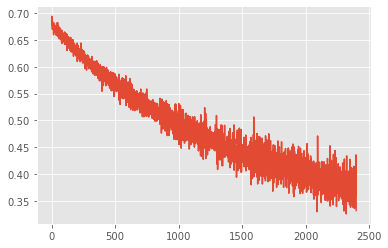

In [13]:
plt.plot(lr.loss_hist)

In [21]:
class SoftmaxRegression :
    def __init__(self, 
                 steps : int = 300, 
                 lr : float = 0.01,
                 use_bias : bool = True,
                 init : str = "normal"):
        self.steps = steps
        self.lr = lr
        self.use_bias = use_bias
        self.init = init.lower()
        
    def fit(self, X, y, batch_size = 32):
        X, y = np.array(X), np.array(y)
        assert batch_size <= len(X), "Batch size can't be bigger than size of the data."
        assert len(X) == len(y), f"Feature size {len(X)} has different size with label size len(y)"
        y_ohe = self.__OneHot(y)
        losses = []
        N, m = X.shape
        if self.init == "normal":
            w = np.random.normal(0, 0.05, size=(m, y_ohe.shape[1]))
            b = np.random.normal(0, 0.05, size=(y_ohe.shape[1]))
        elif self.init == "uniform":
            w = np.random.uniform(low=-0.05, high=0.05, size=(m, y_ohe.shape[1]))
            b = np.random.uniform(low=-0.05, high=0.05, size=(y_ohe.shape[1]))
        else :
            raise ValueError("Weights initializer is not valid.. Use normal or uniform.")
        
        for _ in range(self.steps):
            perm = np.random.permutation(N)
            X_perm, y_perm, y_perm_ohe = X[perm], y[perm], y_ohe[perm]
            for batch in range(0, N, batch_size):
                X_batch, y_batch, y_ohe_batch = X_perm[batch:batch+batch_size], y_perm[batch:batch+batch_size], y_perm_ohe[batch:batch+batch_size]
                if self.use_bias :
                    y_prob = self.__softmax(np.dot(X_batch, w)) + b
                    dw, db = self.__gradientDescent(X_batch, y_ohe_batch, y_prob)
                    w, b = self.__update(w, dw, b, db)
                    loss = self.__categoryLogLoss(y_batch, y_prob)
                    losses.append(loss)
                     
                else :
                    z = self.__softmax(np.dot(X_batch, w))
                    dw = self.__gradientDescent(X_batch, y_ohe_batch, y_prob)
                    w = self.__update(w, dw)
                    loss = SoftmaxRegression.categoryLogLoss(y_batch, y_prob)
                    losses.append(loss)

        self.w, self.b = w, b
        self.m = m
        self.loss_hist = np.array(losses)
        
    def predict(self, X):
        X = np.array(X)
        assert X.shape[1] == self.m, f"{X.shape[1]} has not the same shape as fit !"
        if self.use_bias : 
            z = self.__softmax(np.dot(X, self.w))
        else :
            z = self.__softmax(np.dot(X, self.w))
        return np.argmax(z, axis=-1)
    
    def __gradientDescent(self, X, y_true, y_hat):
        if self.use_bias : 
            dw = (1 / len(X)) * np.dot(X.T, (y_hat - y_true)) # Calculate gradient descent for the weights
            db =  (1 / len(X)) * np.sum(y_hat - y_true) # Calculate gradient descent for the bias
            return dw, db
        else : 
            dw = (1 / len(X)) * np.dot(X.T, (y_hat - y_true))
            return dw

    def __update(self, w, dw, b = None, db = None):
        if self.use_bias:
            w = w - self.lr * dw
            b = b - self.lr * db
            return w, b
        else :
            w = w - self.lr * dw
            return w
        
    def __softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / exp_z.sum()
    
    def __OneHot(self, y):
        y_ohe = np.zeros((len(y), len(np.unique(y))))
        y_ohe[np.arange(len(y)), y] = 1
        return y_ohe
    
    def __categoryLogLoss(self, y_true, y_pred):
        return - np.mean(np.log(y_pred[np.arange(len(y_true)), y_true]))

In [22]:
sr = SoftmaxRegression()
sr.fit(sc_train, y_train)

/var/folders/qz/dh4v_63j3pzcxc4r0z6gl2940000gp/T/ipykernel_56139/831305109.py:88: RuntimeWarning: invalid value encountered in log
  return - np.mean(np.log(y_pred[np.arange(len(y_true)), y_true]))


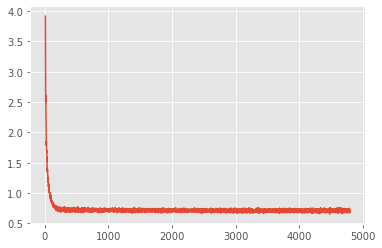

In [25]:
plt.plot(sr.loss_hist)

In [24]:
sr.predict(sc_val)

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])